# VVV vs F405N reference catalog

In [1]:
%matplotlib inline
import pylab as pl

In [2]:
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import coordinates
import numpy as np

In [3]:
basepath = '/orange/adamginsburg/jwst/brick/'
abs_refcat = f'{basepath}/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog.ecsv'
abs_refcat = f'{basepath}/catalogs/dao_basic_based_nircam-f405n_reference_astrometric_catalog.ecsv'
reftbl = Table.read(abs_refcat)

In [4]:
vvvtb = Table.read(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged_vvvcat.ecsv')

In [5]:
len(vvvtb)

4693

In [6]:
vvvcrds = SkyCoord(vvvtb['RAJ2000'].quantity, vvvtb['DEJ2000'].quantity, frame='fk5')

In [7]:
refcrds = reftbl['skycoord']

In [8]:
idx, sidx, sep, _ = refcrds.search_around_sky(vvvcrds, 0.2*u.arcsec)
keep = np.array([(ii == idx).sum() == 1 or (sp == sep[idx == ii].min()) for ii, sp in zip(idx, sep)])
print(len(idx), len(set(idx)), len(sidx), len(set(sidx)), keep.sum())
idx = idx[keep]
sidx = sidx[keep]
print(len(idx), len(set(idx)), len(sidx), len(set(sidx)), keep.sum(), sep[keep].mean())

3991 3043 3991 3982 3043
3043 3043 3043 3035 3043 0d00m00.08149746s


In [9]:
dra = (refcrds[sidx].ra - vvvcrds[idx].ra).to(u.arcsec)
ddec = (refcrds[sidx].dec - vvvcrds[idx].dec).to(u.arcsec)

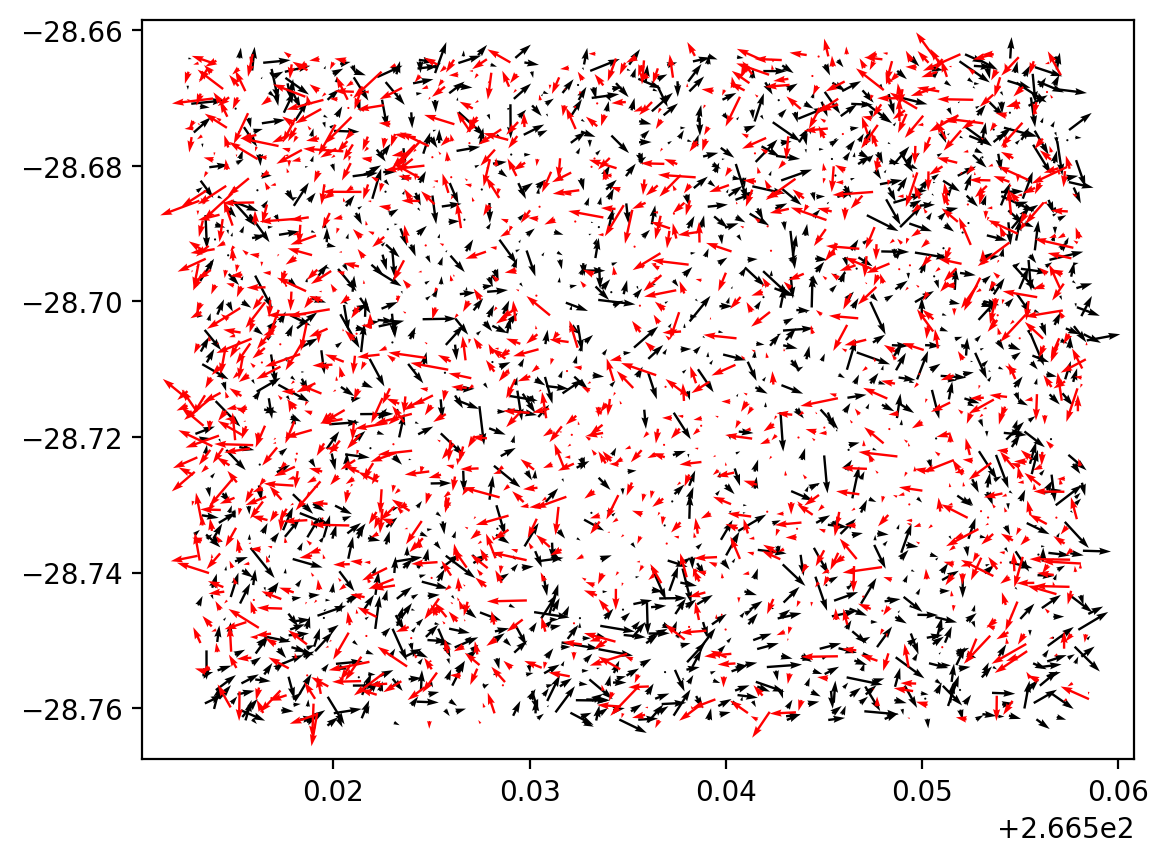

In [10]:
pl.figure(dpi=200)
pl.quiver(refcrds[sidx][dra>0].ra.value, refcrds[sidx][dra>0].dec.value, dra.to(u.arcsec).value[dra>0], ddec.to(u.arcsec).value[dra>0])
pl.quiver(refcrds[sidx][dra<0].ra.value, refcrds[sidx][dra<0].dec.value, dra.to(u.arcsec).value[dra<0], ddec.to(u.arcsec).value[dra<0], color='r')

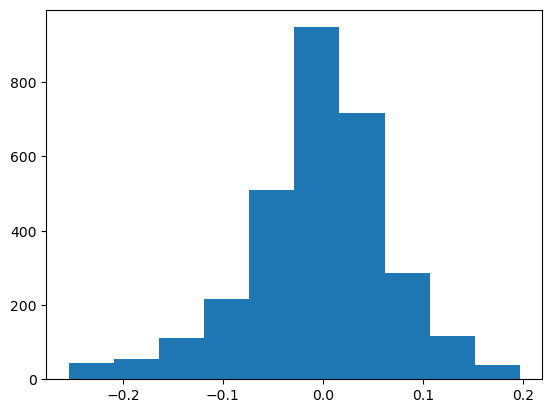

In [11]:
pl.hist(dra);

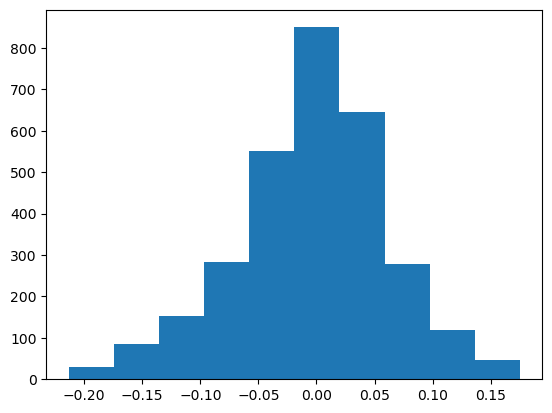

In [12]:
pl.hist(ddec);

In [13]:
from astroquery.svo_fps import SvoFps
from astropy import wcs
from astropy.io import fits
import numpy as np
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')
zeropoint = u.Quantity(jfilts.loc[f'JWST/NIRCam.F405N']['ZeroPoint'], u.Jy)
#sqpixscale = wcs.WCS(fits.getheader(reftbl.meta['FILENAME'], ext=1)).proj_plane_pixel_area()
try:
    flux_jy = (reftbl['flux'] * u.MJy/u.sr * (reftbl.meta['pixscale_as']*u.arcsec)**2).to(u.Jy)
except KeyError:
    flux_jy = (reftbl['flux_fit'] * u.MJy/u.sr * (reftbl.meta['PIXSCALE']*u.deg)**2).to(u.Jy)
mag405 = -2.5 * np.log10(flux_jy / zeropoint) * u.mag

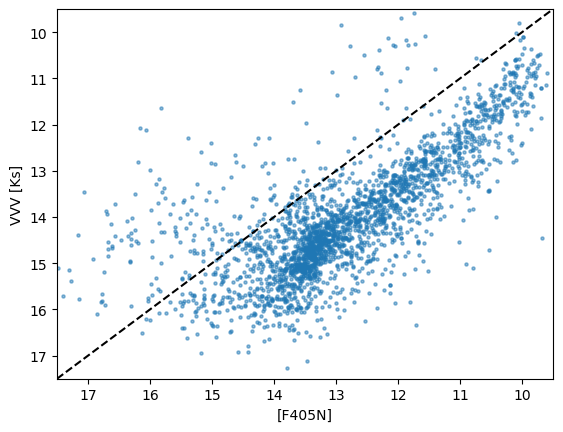

In [14]:
pl.plot([17.5, 9.5], [17.5, 9.5], 'k--')
pl.scatter(mag405[sidx], vvvtb['Ksmag3'][idx], alpha=0.5, s=5);
pl.axis([17.5, 9.5, 17.5, 9.5]);
pl.xlabel("[F405N]")
pl.ylabel("VVV [Ks]");

(array([   6.,   22.,   71.,  178.,  310.,  618., 1148., 1063.,  356.,
          30.]),
 array([ 7.647,  8.63 ,  9.613, 10.596, 11.579, 12.562, 13.545, 14.528,
        15.511, 16.494, 17.477]),
 <BarContainer object of 10 artists>)

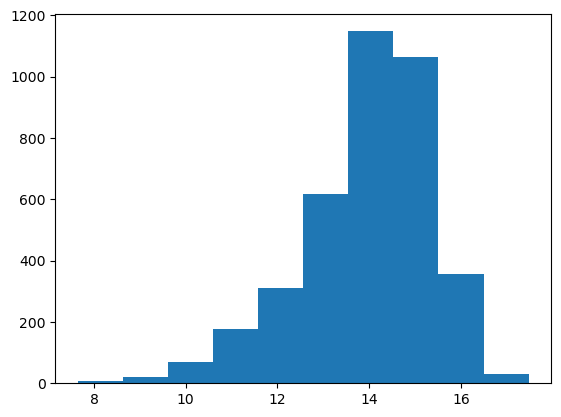

In [15]:
pl.hist(vvvtb['Ksmag3'])

In [16]:
from astropy import stats
ratio = vvvtb['Ksmag3'][idx] - mag405[sidx]
#reject = np.zeros(ratio.size, dtype='bool')
reject = ~np.isfinite(ratio)
for ii in range(12):
    madstd = stats.mad_std(ratio[~reject])
    med = np.median(ratio[~reject])
    print(f'{med} +/- {madstd}   n={(~reject).sum()}')
    reject = (ratio < med - 3 * madstd) | (ratio > med + 3 * madstd) | reject
    assert reject.sum() < reject.size

1.158384049588749 +/- 0.5852400698806821   n=2508
1.1805653023308356 +/- 0.5233718358462905   n=2322
1.1789813752924392 +/- 0.5076779694643919   n=2279
1.177770409653018 +/- 0.505846143556427   n=2265
1.1782974765786562 +/- 0.5050586182386452   n=2264
1.1782974765786562 +/- 0.5050586182386452   n=2264
1.1782974765786562 +/- 0.5050586182386452   n=2264
1.1782974765786562 +/- 0.5050586182386452   n=2264
1.1782974765786562 +/- 0.5050586182386452   n=2264
1.1782974765786562 +/- 0.5050586182386452   n=2264
1.1782974765786562 +/- 0.5050586182386452   n=2264
1.1782974765786562 +/- 0.5050586182386452   n=2264


/blue/adamginsburg/adamginsburg/miniconda3/envs/python310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


(array([1.000e+00, 0.000e+00, 5.000e+00, 3.500e+01, 8.300e+01, 7.080e+02,
        1.094e+03, 1.008e+03, 1.000e+02, 9.000e+00]),
 array([-6.59179367, -5.45402647, -4.31625926, -3.17849205, -2.04072484,
        -0.90295763,  0.23480958,  1.37257678,  2.51034399,  3.6481112 ,
         4.78587841]),
 <BarContainer object of 10 artists>)

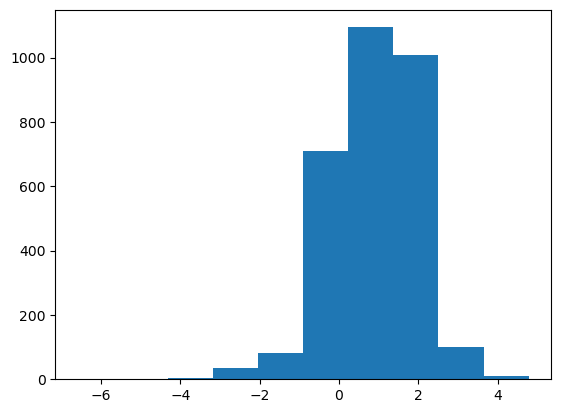

In [17]:
pl.hist(ratio)

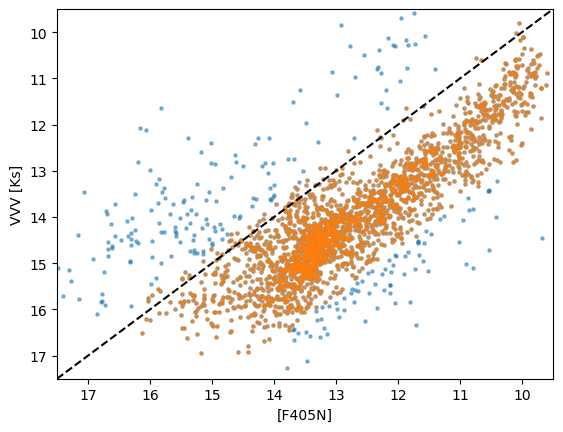

In [18]:
pl.plot([17.5, 9.5], [17.5, 9.5], 'k--')
pl.scatter(mag405[sidx], vvvtb['Ksmag3'][idx], alpha=0.5, s=5);
pl.scatter(mag405[sidx][~reject], vvvtb['Ksmag3'][idx][~reject], alpha=0.5, s=5);
pl.axis([17.5, 9.5, 17.5, 9.5]);
pl.xlabel("[F405N]")
pl.ylabel("VVV [Ks]");

In [19]:
#dra = (refcrds[sidx].ra - vvvcrds[idx].ra).to(u.arcsec)
#ddec = (refcrds[sidx].dec - vvvcrds[idx].dec).to(u.arcsec)
dra_med, ddec_med = np.median(dra[~reject]), np.median(ddec[~reject])
dra_med, ddec_med

(<Angle 0.00136359 arcsec>, <Angle 0.00180639 arcsec>)

In [20]:
refcrds_updated = SkyCoord(refcrds.ra - dra_med,  refcrds.dec - ddec_med, frame=refcrds.frame)

In [21]:
keep = np.zeros(len(reftbl), dtype='bool')
keep[sidx] = True
keep[sidx[reject]] = False
reftbl['keep'] = keep

In [22]:
reftbl['keep'].sum(), keep.sum(), reject.sum(), (~reject).sum()

(2791, 2791, 244, 2264)

In [23]:
idx_updated, sidx_updated, sep, _ = refcrds_updated.search_around_sky(vvvcrds, 0.2*u.arcsec)
keep = np.array([(ii == idx_updated).sum() == 1 or (sp == sep[idx_updated == ii].min()) for ii, sp in zip(idx_updated, sep)])
print(len(idx_updated), len(set(idx_updated)), len(sidx_updated), len(set(sidx_updated)), keep.sum())
idx_updated = idx_updated[keep]
sidx_updated = sidx_updated[keep]

print(len(idx_updated))

3982 3043 3982 3973 3043
3043


In [24]:
dra_updated = (refcrds_updated[sidx_updated].ra - vvvcrds[idx_updated].ra).to(u.arcsec)
ddec_updated = (refcrds_updated[sidx_updated].dec - vvvcrds[idx_updated].dec).to(u.arcsec)
dra_med_updated, ddec_med_updated = np.median(dra_updated), np.median(ddec_updated)
dra_med_updated, ddec_med_updated

(<Angle -0.0001481 arcsec>, <Angle -0.00092726 arcsec>)

In [25]:
dra_updated.std(), ddec_updated.std()

(<Angle 0.07167209 arcsec>, <Angle 0.06458491 arcsec>)

In [26]:
tbl = reftbl

In [27]:
%run /orange/adamginsburg/jwst/brick/analysis/make_reftable.py


f405n
crowdsource /blue/adamginsburg/adamginsburg/jwst/brick//catalogs/f405n_merged_indivexp_merged_crowdsource_nsky0.fits
QFs are good for 124330 out of 543005 catalog entries
Making the reference catalog from 124330 out of 543005 catalog entries


/blue/adamginsburg/adamginsburg/miniconda3/envs/python310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


     ,    ,      ,    0.001,   -0.001,    0.001,   -0.001,    0.057,    0.056,   2644,      17,     1
Shifted f405n coordinates by 0.0011490519000290078 arcsec, -0.0006431070843859743 arcsec in 1 iterations with stddev = 0.05671185712175132 arcsec, 0.05575095618231924 arcsec (0.0795261205733111 arcsec)
Total of 2644 stars were used.
dao_basic /blue/adamginsburg/adamginsburg/jwst/brick//catalogs/f405n_merged_indivexp_merged_dao_basic.fits
QFs are good for 74168 out of 244771 catalog entries
Making the reference catalog from 74168 out of 244771 catalog entries
     ,    ,      ,    0.001,    0.000,    0.001,    0.000,    0.054,    0.054,   3035,      99,     1


/blue/adamginsburg/adamginsburg/miniconda3/envs/python310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Shifted f405n coordinates by 0.001010354117170209 arcsec, 0.0002951409612705902 arcsec in 1 iterations with stddev = 0.05372550206815773 arcsec, 0.05421285135322237 arcsec (0.07632471961509066 arcsec)
Total of 3035 stars were used.

f200w
crowdsource /blue/adamginsburg/adamginsburg/jwst/brick//catalogs/f200w_merged_indivexp_merged_crowdsource_nsky0.fits
QFs are good for 246712 out of 4727344 catalog entries
Making the reference catalog from 246712 out of 4727344 catalog entries


/blue/adamginsburg/adamginsburg/miniconda3/envs/python310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


     ,    ,      ,    0.009,    0.061,    0.002,    0.008,    0.065,    0.068,   2999,      60,     2
Shifted f200w coordinates by 0.009146096283529914 arcsec, 0.06096474144072772 arcsec in 2 iterations with stddev = 0.06499034437009177 arcsec, 0.06831431904149755 arcsec (0.0942899307850347 arcsec)
Total of 2999 stars were used.
dao_basic /blue/adamginsburg/adamginsburg/jwst/brick//catalogs/f200w_merged_indivexp_merged_dao_basic.fits
QFs are good for 1087316 out of 1947266 catalog entries
Making the reference catalog from 1087316 out of 1947266 catalog entries


/blue/adamginsburg/adamginsburg/miniconda3/envs/python310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


     ,    ,      ,    0.026,    0.068,    0.004,    0.006,    0.079,    0.067,   5651,      17,     3
Shifted f200w coordinates by 0.026464612926702102 arcsec, 0.06750449432075811 arcsec in 3 iterations with stddev = 0.07886759527384112 arcsec, 0.0670679152441067 arcsec (0.10352875368451551 arcsec)
Total of 5651 stars were used.

f444w
crowdsource /blue/adamginsburg/adamginsburg/jwst/brick//catalogs/f444w_merged_indivexp_merged_crowdsource_nsky0.fits
QFs are good for 53178 out of 1907067 catalog entries
Making the reference catalog from 53178 out of 1907067 catalog entries


/blue/adamginsburg/adamginsburg/miniconda3/envs/python310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


     ,    ,      ,    0.002,    0.038,    0.000,    0.008,    0.066,    0.068,   2572,       1,     2
Shifted f444w coordinates by 0.0016681168062859797 arcsec, 0.03830102821140713 arcsec in 2 iterations with stddev = 0.06595183031051285 arcsec, 0.068033287067487 arcsec (0.09475321667634179 arcsec)
Total of 2572 stars were used.
dao_basic /blue/adamginsburg/adamginsburg/jwst/brick//catalogs/f444w_merged_indivexp_merged_dao_basic.fits
QFs are good for 317358 out of 583139 catalog entries
Making the reference catalog from 317358 out of 583139 catalog entries


/blue/adamginsburg/adamginsburg/miniconda3/envs/python310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


     ,    ,      ,    0.013,    0.057,    0.001,    0.005,    0.073,    0.071,   4204,      78,     3
Shifted f444w coordinates by 0.013251280086024053 arcsec, 0.057188591718215775 arcsec in 3 iterations with stddev = 0.07263270217632628 arcsec, 0.07107800029784211 arcsec (0.10162475855703154 arcsec)
Total of 4204 stars were used.


<Figure size 640x480 with 0 Axes>

In [28]:
vvvcrds, refcrds
matches, sep, _ = vvvcrds.match_to_catalog_sky(refcrds, nthneighbor=1)
revmatches, revsep, _ = refcrds.match_to_catalog_sky(vvvcrds, nthneighbor=1)
len(matches), len(revmatches), len(refcrds), len(vvvcrds)

(4693, 74168, 74168, 4693)

In [29]:
matches[revmatches]

array([  177,    29,     2, ...,  1631, 11282,  5798])

In [30]:
mutual_matches = (matches[revmatches] == np.arange(len(revmatches)))
mutual_matches.sum(), len(mutual_matches)

(3754, 74168)

In [31]:
mutual_revmatches = (revmatches[matches] == np.arange(len(matches)))
mutual_revmatches.sum(), len(mutual_revmatches)

(3754, 4693)

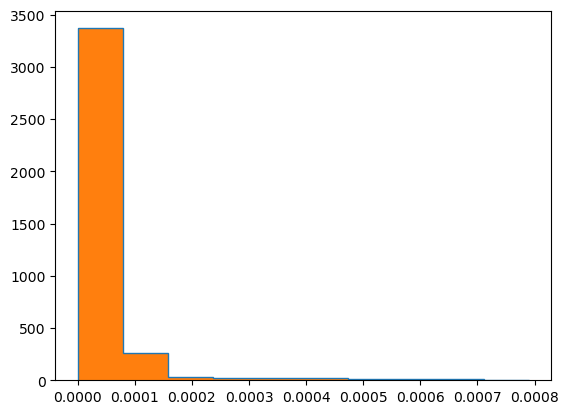

In [32]:
pl.hist(revsep[matches[mutual_revmatches]], histtype='step');
pl.hist(sep[revmatches[mutual_matches]], histtype='stepfilled');

In [33]:
revmatches.max(), matches.max()

(4687, 73571)

In [34]:
crds = vvvcrds
basecrds = refcrds

matches, sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)
reverse_matches, reverse_sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
mutual_reverse_matches = (matches[reverse_matches] == np.arange(len(reverse_matches)))
mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))
print(basecrds.shape, crds.shape, mutual_matches.shape, mutual_reverse_matches.shape, matches.shape, reverse_matches.shape)

# do one iteration of bulk offset measurement
radiff = (basecrds.ra[matches[mutual_matches]] - crds[mutual_matches].ra).to(u.arcsec)
decdiff = (basecrds.dec[matches[mutual_matches]] - crds[mutual_matches].dec).to(u.arcsec)
radiff

(74168,) (4693,) (4693,) (74168,) (4693,) (74168,)


<Angle [ 0.03341236, -0.01325396,  0.57388003, ..., -0.05468683,
        -0.21519136,  0.05071055] arcsec>

In [35]:
matches.max(), reverse_matches.max()

(73571, 4687)

(array([ 63., 148., 353., 691., 656., 399., 212., 102.,  69.,  18.]),
 array([-0.14143667, -0.10749604, -0.07355542, -0.03961479, -0.00567416,
         0.02826647,  0.0622071 ,  0.09614773,  0.13008835,  0.16402898,
         0.19796961]),
 <BarContainer object of 10 artists>)

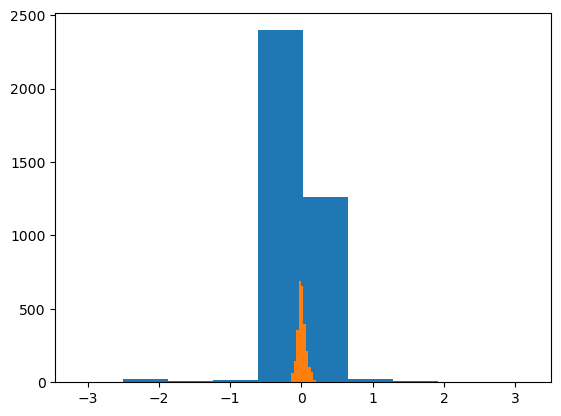

In [36]:
max_offset = 0.15*u.arcsec

matches, sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)
reverse_matches, reverse_sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
mutual_reverse_matches = (matches[reverse_matches] == np.arange(len(reverse_matches)))
mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))

# do one iteration of bulk offset measurement
radiff = (crds.ra[reverse_matches[mutual_reverse_matches]] - basecrds[mutual_reverse_matches].ra).to(u.arcsec)
decdiff = (crds.dec[reverse_matches[mutual_reverse_matches]] - basecrds[mutual_reverse_matches].dec).to(u.arcsec)
pl.hist(radiff)

# don't allow sep=0, since that's self-reference.  Use stringent qf, fracflux
oksep = (sep < max_offset) & (sep != 0) & mutual_matches
oksep = (sep[reverse_matches[mutual_reverse_matches]] < max_offset)
pl.hist(radiff[oksep])

In [37]:
crds[reverse_matches[mutual_reverse_matches]][:2]

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(266.536049, -28.759902), (266.51732 , -28.753518)]>

In [38]:
basecrds[matches[mutual_matches]][:2]

<SkyCoord (ICRS): (ra, dec) in deg
    [(266.53041028, -28.76154461), (266.52749632, -28.76223818)]>

In [39]:
mutual_matches

array([False, False,  True, ..., False, False, False])

In [40]:
mutual_reverse_matches

array([False, False,  True, ..., False, False, False])

In [41]:
matches[mutual_matches]

array([  578, 34796,  3633, ..., 22402, 34953,  8543])

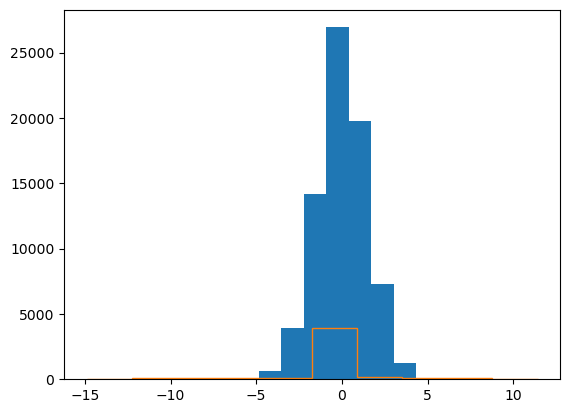

In [42]:
pl.hist((crds.ra[reverse_matches] - basecrds.ra).to(u.arcsec).value)
pl.hist((crds.ra - basecrds.ra[matches]).to(u.arcsec).value, histtype='step');

In [43]:
basecrds[matches]

<SkyCoord (ICRS): (ra, dec) in deg
    [(266.5271611 , -28.76226214), (266.52749632, -28.76223818),
     (266.53041028, -28.76154461), ..., (266.51665948, -28.66352362),
     (266.53897951, -28.6634836 ), (266.53244893, -28.66345704)]>